# Synchronizing signals 

In [72]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate
from dtw import dtw, accelerated_dtw
from scipy.stats import wasserstein_distance, energy_distance

## functions

In [73]:
def aggregate(signal, time, interval, f=np.mean):
    relative_time = time - time[0]
    mask = np.zeros(relative_time.size)
    
    window_index = 0
    acc_interval = interval
    for i, t in enumerate(relative_time):
        if t >= acc_interval:
            acc_interval += interval
            window_index += 1
            mask[i] = window_index
        else:
            mask[i] = window_index
            
    unique_index, index_count = np.unique(mask, return_counts=True)
    
    res_signal = np.zeros(unique_index.size)
    res_time = np.zeros(unique_index.size)
    
    for i, idx_w in enumerate(unique_index):
        res_signal[i] = f(signal[mask == idx_w])
        res_time[i] = time[mask == idx_w][0]
    
    if index_count[-1] < index_count[0]:
        res_signal = res_signal[0:-1]
        res_time = res_time[0:-1]
        
    return res_signal, res_time


def slide(sig_static, sig_slide, f):
    res_size = len(sig_static) + len(sig_slide) - 1
    res = np.zeros(res_size)
    
    index = 0
    for i in range(0, len(sig_slide)):
        slide_idx = len(sig_slide) - i - 1
        static_idx = i + 1
        res[index] = f(sig_static[:static_idx], sig_slide[slide_idx:])
        index += 1
        
    for i in range(1, len(sig_static) - len(sig_slide) + 1):
        static_idx = i + len(sig_slide)
        res[index] = f(sig_static[i:static_idx], sig_slide)
        index += 1
        
    for i in range(1, len(sig_slide)):
        slide_idx = len(sig_slide) - i
        static_idx = len(sig_static) - len(sig_slide) + i
        res[index] = f(sig_static[static_idx:], sig_slide[:slide_idx])
        index += 1
    
    res[np.isnan(res)] = 0
    
    return res

def calc_time_shift(metric_func, sig1, sig2, time1=None, time2=None, cut=(0, 0), debug=False):
    metric = slide(sig1, sig2, metric_func)
    metric_cut = metric.copy()
    metric_cut[:cut[0]] = metric.min()
    metric_cut[metric_cut.size-cut[1]:] = metric.min()
    max_disp = np.argmax(metric_cut) - len(sig2) + 1
    
    if debug:
        xaxis = np.arange(0, len(metric)) - len(sig2) + 1
        plt.figure()
        plt.plot(xaxis, metric_cut)
        plt.axvline(max_disp, c='r', label=f'Max (d = {max_disp})', alpha=0.6)
        plt.title(f.__name__, FontSize=14)
        plt.ylabel('correlation', FontSize=14)
        plt.xlabel('displacement', FontSize=14)
        plt.legend()
        plt.show()
    
    if (time1 is not None) and (time2 is not None):
        time_diff = time2[0] - time1[max_disp]
        if debug:
            print(f'time short start - time short actual start = {time_diff}')
        return time_diff
    
    return max_disp

def get_parts_time_shift(metric_func, n_parts, sig1, sig2, time1=None, time2=None, cut=(0,0), debug=False):
    n_samples_per_part = sig2.size//n_parts
    n_samples_last_part = sig2.size % n_parts
    shifts = []
    for i in range(n_parts):
        start = i*n_samples_per_part
        end = (i+1)*n_samples_per_part + (n_samples_last_part > 0)
        sig2_part = sig2[start:end] 
        time2_part = time2[start:end] 
        shift = calc_time_shift(metric_func, sig1, sig2_part, time1, time2_part, cut, debug=debug)
        shifts.append(shift)
        n_samples_last_part -= 1
    return shifts 

def pearson_correlation(sig1, sig2):
    return np.corrcoef(sig1, sig2)[0,1]

def dtw_metric(sig1, sig2):
    min_cost, _, _, _ = accelerated_dtw(sig1, sig2, dist='euclidean')
    return -min_cost

def wass_dist_metric(sig1, sig2):
    return -wasserstein_distance(sig1,sig2)

def energy_dist_metric(sig1, sig2):
    return -energy_distance(sig1,sig2)

def cross_correlation(sig1, sig2, time1=None, time2=None, debug=False):
    """ 
    Cross-correlation is given by:
    
        c(sig1, sig2)[k] = sum(sig1[n+k] * sig2[n])
        
    for k in [-len(sig2)+1, len(sig1)-1]. Basically,
    it takes signal 1 and slide it until its first value
    aligns with signal 2 last value. Then it slides it to
    to the left until signal 1 last value aligns with signal
    2 last value, as shown below:
    
        sig1  1 2 3 4 5
        sig2  1 2 3 4
        
        c[-3] = 4  ->                1 2 3 4 5
                               1 2 3 4
                               
                      
        c[-2] = 11 ->              1 2 3 4 5
                               1 2 3 4
                               
                         
        c[0]  = 30 ->          1 2 3 4 5
                               1 2 3 4
                               
                          
        c[4]  = 5  ->  1 2 3 4 5
                               1 2 3 4
                               
    The displacement with maximum correlated id obtained
    with np.argmax and then the distance of this displacement
    from the begginning of the signal 1 is calculated. That value
    is returned. For the example above, the returned value
    would be 0.
        
    If the timestamps of both signals are fed into the function,
    then the value returned is the difference, in the same time
    units:
        
        deltaT = [signal 2 beggin time] - [signal 1 max displacement time]
        
    deltaT can be interpreted as the delay of signal 2 timestamp 
    relative to signal 1 timestamp.
        
    If one wants to adjust both timestamps they can:
        
        1. add deltaT to all signal 1 timestamps; OR
        2. subtract deltaT from all signal 2 timestamps
        
    This way both signals will be synchronized according to 
    signal 1 timestamp (first case) or signal 2 timestamp
    (second case).
        
    Args:
        sig1  -- 1D numpy array with signal 1.
        
        sig2  -- 1D numpy array with signal 2.
        
        time1 -- Optional (default=None). 1D numpy array with signal 1 timestamps.
        
        time2 -- Optional (default=None). 1D numpy array with signal 2 timestamps.
        
        debug -- Optional (default=False). True for displaying a plot of the cross correlation
        as a function of the displacement.
        
    Returns:
        max_disp if time1 or time2 equals None, otherwise returns time_diff.
                      
    """
    crosscorr = correlate(sig1, sig2, 'full')
    max_disp = np.argmax(crosscorr) - len(sig2) + 1
    
    if debug:
        xaxis = np.arange(0,len(crosscorr)) - len(sig2) + 1
        plt.figure()
        plt.plot(xaxis, crosscorr)
        plt.axvline(max_disp, c='r', label=f'Max (d = {max_disp})', alpha=0.6)
        plt.title('Cross Correlation', FontSize=14)
        plt.ylabel('correlation', FontSize=14)
        plt.xlabel('displacement', FontSize=14)
        plt.legend()
        plt.show()
    
    if (time1 is not None) and (time2 is not None):
        time_diff = time2[0] - time1[max_disp]
        if debug:
            print(f'time short start - time short actual start = {time_diff}')
        return time_diff
    
    return max_disp


def get_parts_time_shift_cross_corr(n_parts, sig1, sig2, time1=None, time2=None, debug=False):
    n_samples_per_part = sig2.size//n_parts
    n_samples_last_part = sig2.size % n_parts
    shifts = []
    for i in range(n_parts):
        start = i*n_samples_per_part
        end = (i+1)*n_samples_per_part + (n_samples_last_part > 0)
        sig2_part = sig2[start:end] 
        time2_part = time2[start:end] 
        shift = cross_correlation(sig1, sig2_part, time1, time2_part, debug=debug)
        shifts.append(shift)
        n_samples_last_part -= 1
    return shifts

## Defining signals

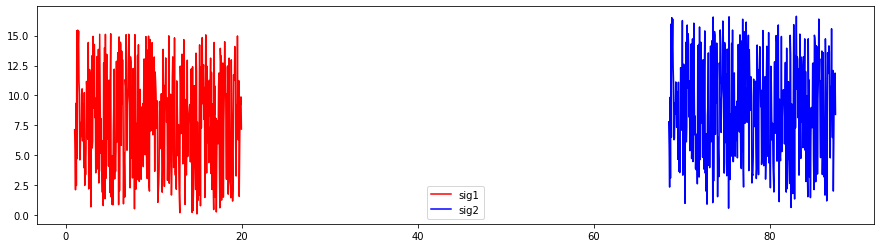

In [143]:
# defining signals

def f(x):
    return 1/x

time1 = np.arange(1, 20, 0.05)
noise = np.random.rand(time1.size)*15
sig1 = f(time1)+noise

distance = 67.5
a = 0
b = time1.size

time2 = time1[a:b] + distance 
sig2 = sig1[a:b] + 2*np.random.rand(time2.size)

# df1 = pd.DataFrame({'time': time1, 'sig1': sig1})
# df2 = pd.DataFrame({'time': time2, 'sig2': sig2})
# df = pd.merge(df1,df2,on='time',how='outer')
# sig1 = df.sig1.values.copy()
# sig2 = df.sig2.values.copy()

plt.figure(figsize=(15,4))
plt.plot(time1, sig1, c='r', label='sig1')
plt.plot(time2, sig2, c='b', label='sig2')
plt.legend()

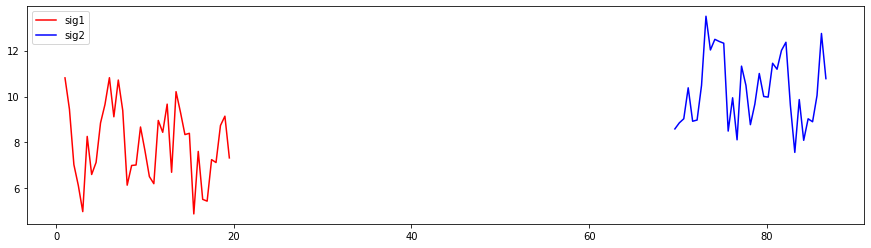

In [49]:
sig1_filt, time1_filt = aggregate(sig1, time1, .5)
sig2_filt, time2_filt = aggregate(sig2, time2, .5)

plt.figure(figsize=(15,4))
plt.plot(time1_filt, sig1_filt, c='r', label='sig1')
plt.plot(time2_filt, sig2_filt, c='b', label='sig2')
plt.legend()

## Cross correlation

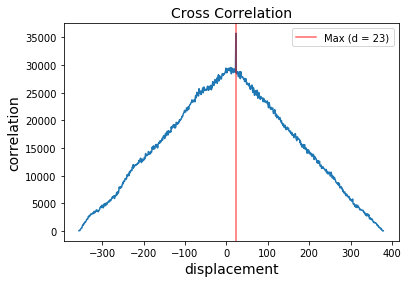

time short start - time short actual start = 67.5


67.5

In [50]:
cross_correlation(sig1, sig2, time1, time2, debug=True)

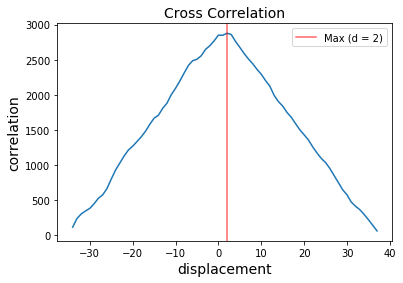

time short start - time short actual start = 67.65


67.65

In [51]:
sig1_filt, time1_filt = aggregate(sig1, time1, .5)
sig2_filt, time2_filt = aggregate(sig2, time2, .5)
cross_correlation(sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True)

#### Subdividing signal into many parts and calculating time shifts for each

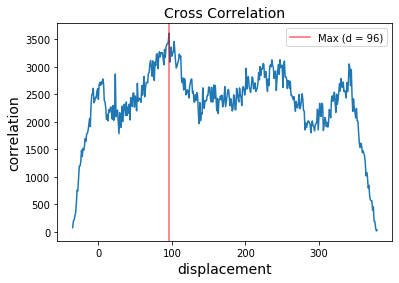

time short start - time short actual start = 63.85


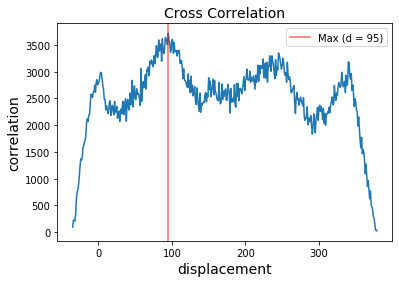

time short start - time short actual start = 65.65


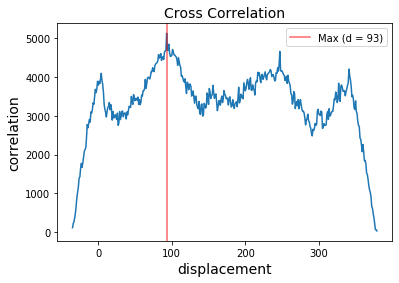

time short start - time short actual start = 67.5


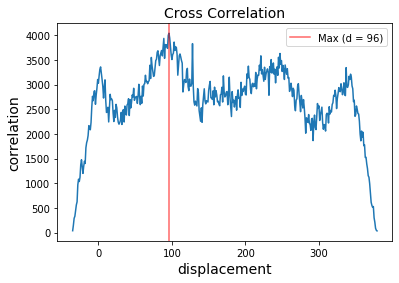

time short start - time short actual start = 69.1


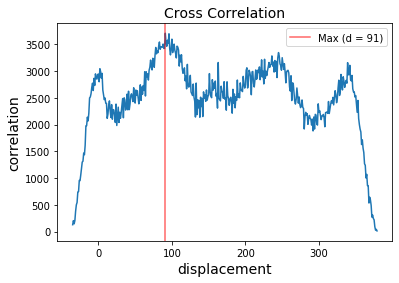

time short start - time short actual start = 71.1


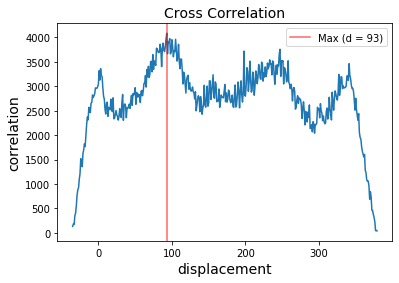

time short start - time short actual start = 72.75


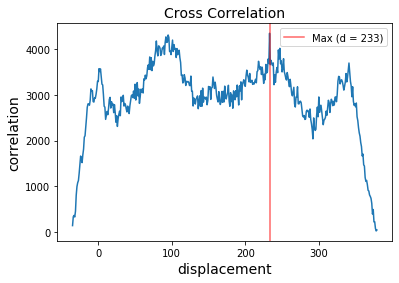

time short start - time short actual start = 67.5


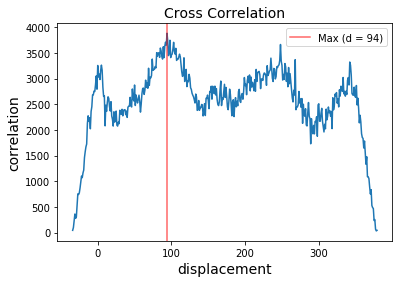

time short start - time short actual start = 76.2


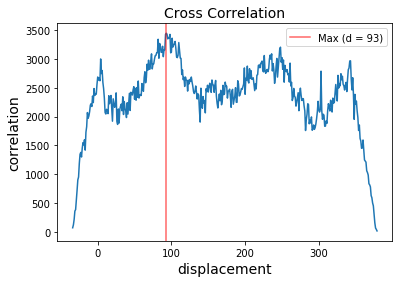

time short start - time short actual start = 78.0


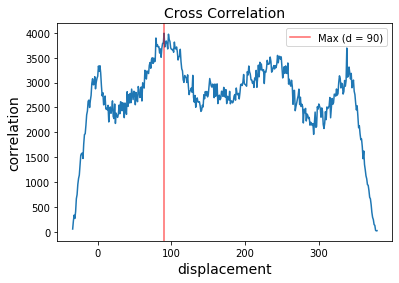

time short start - time short actual start = 79.90000000000002
71.155


In [52]:
res = get_parts_time_shift_cross_corr(10, sig1, sig2, time1, time2, debug=True)
print(np.mean(res))

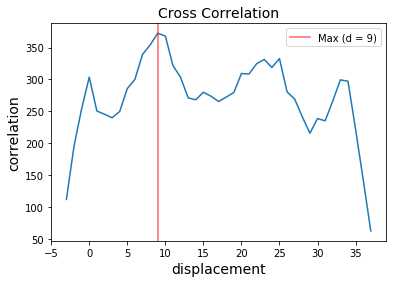

time short start - time short actual start = 64.15


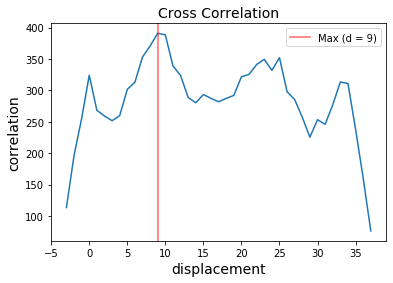

time short start - time short actual start = 65.65


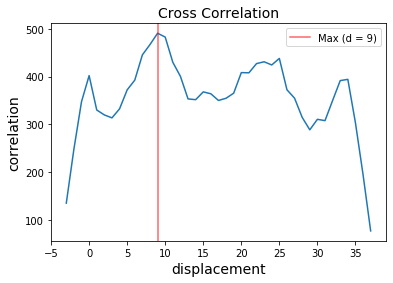

time short start - time short actual start = 67.15


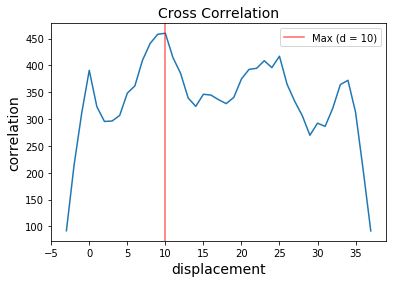

time short start - time short actual start = 68.15


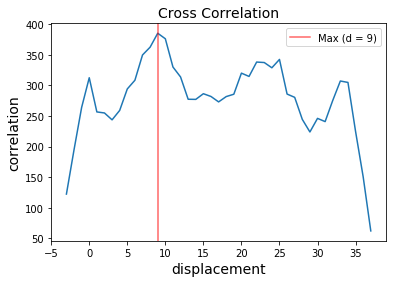

time short start - time short actual start = 70.15


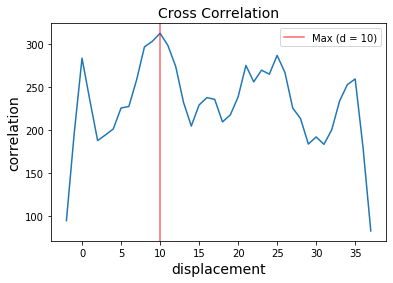

time short start - time short actual start = 71.15


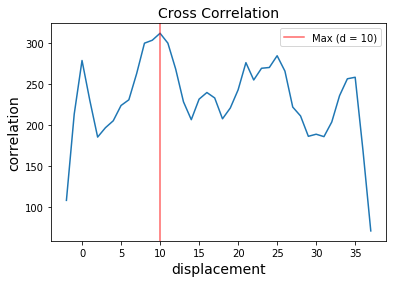

time short start - time short actual start = 72.65


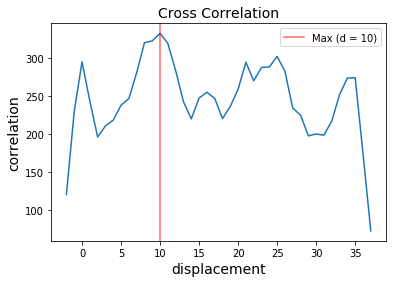

time short start - time short actual start = 74.15


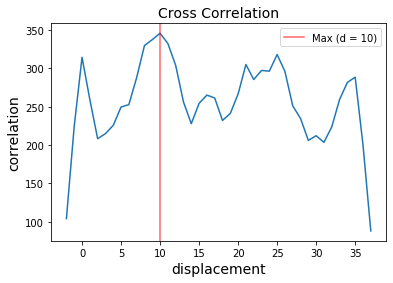

time short start - time short actual start = 75.65


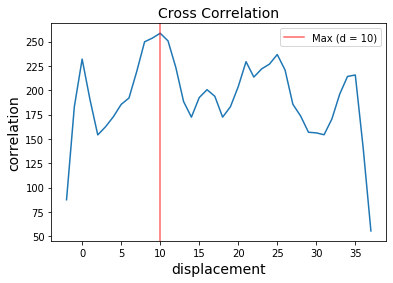

time short start - time short actual start = 77.15
70.6


In [53]:
res = get_parts_time_shift_cross_corr(10, sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True)
print(np.mean(res))

## Pearson's correlation

In [54]:
def pearson_correlation(sig1, sig2):
    return np.corrcoef(sig1, sig2)[0,1]

/Users/vitoral/anaconda3/envs/mlearn/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/vitoral/anaconda3/envs/mlearn/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/vitoral/anaconda3/envs/mlearn/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


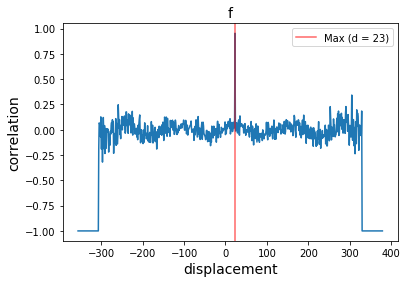

time short start - time short actual start = 67.5


67.5

In [55]:
calc_time_shift(pearson_correlation, sig1, sig2, time1, time2, debug=True, cut=(50 ,50))

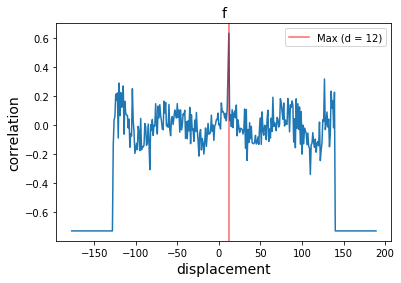

time short start - time short actual start = 67.45


67.45

In [56]:
sig1_filt, time1_filt = aggregate(sig1, time1, .1)
sig2_filt, time2_filt = aggregate(sig2, time2, .1)
calc_time_shift(pearson_correlation, sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True, cut=(50,50))

#### Subdividing signal into many parts and calculating time shifts for each

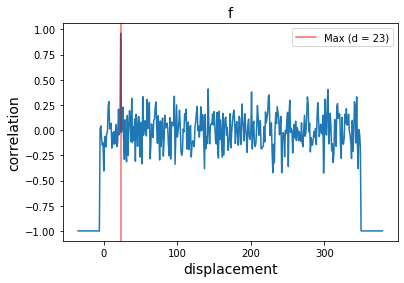

time short start - time short actual start = 67.5


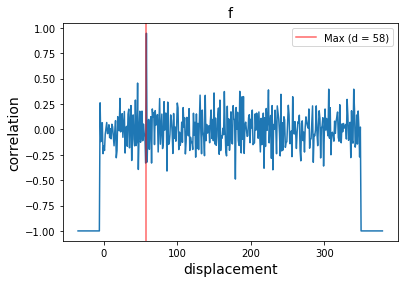

time short start - time short actual start = 67.5


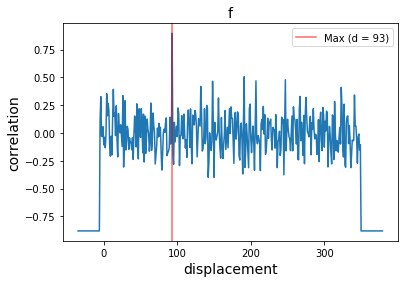

time short start - time short actual start = 67.5


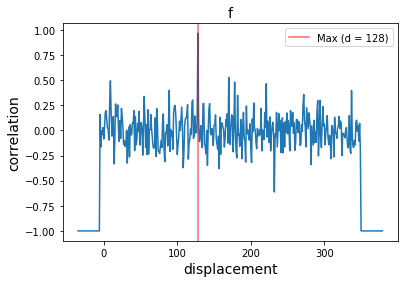

time short start - time short actual start = 67.5


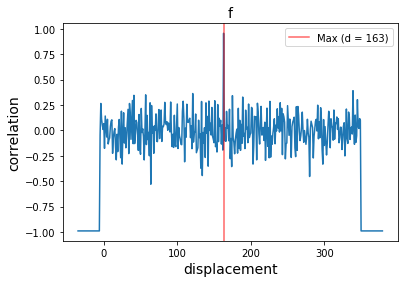

time short start - time short actual start = 67.5


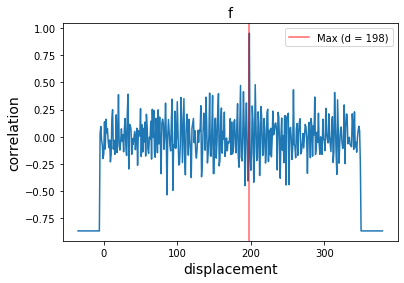

time short start - time short actual start = 67.5


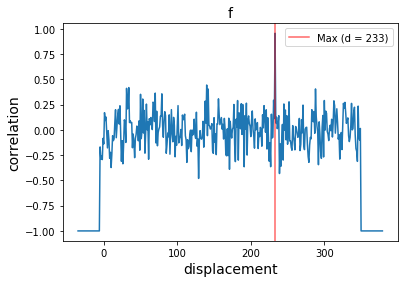

time short start - time short actual start = 67.5


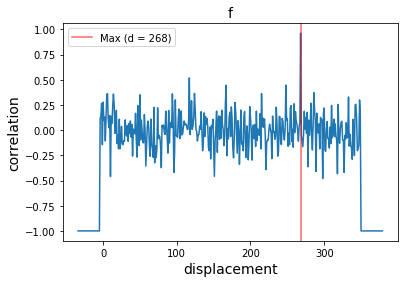

time short start - time short actual start = 67.5


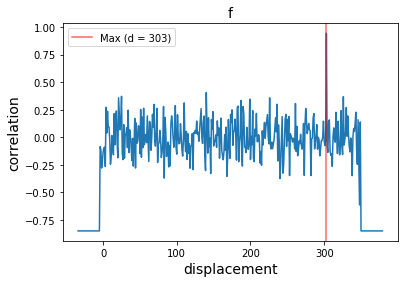

time short start - time short actual start = 67.5


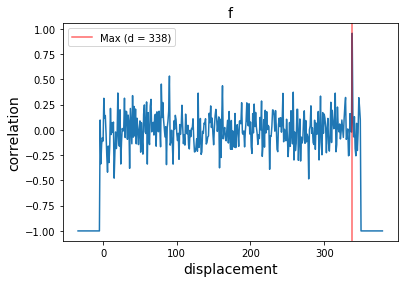

time short start - time short actual start = 67.5
67.5


In [57]:
res = get_parts_time_shift(pearson_correlation, 10, sig1, sig2, time1, time2, debug=True, cut=(30,30))
print(np.mean(res))

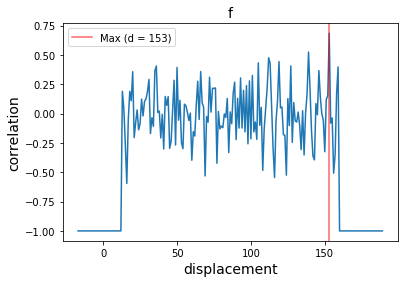

time short start - time short actual start = 53.349999999999994


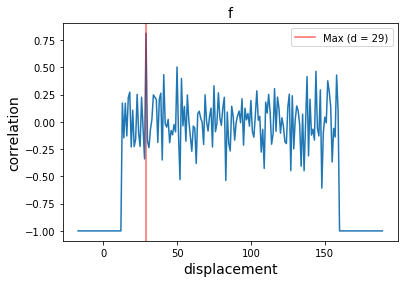

time short start - time short actual start = 67.45


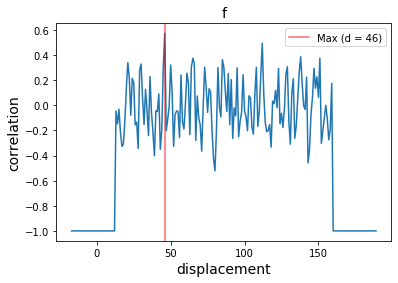

time short start - time short actual start = 67.45


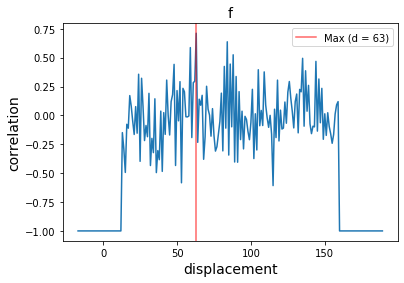

time short start - time short actual start = 67.5


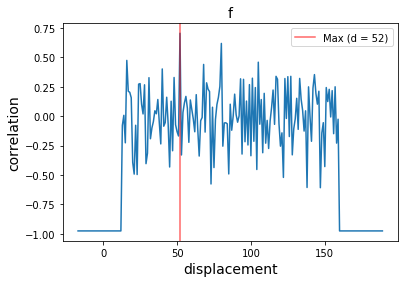

time short start - time short actual start = 70.25


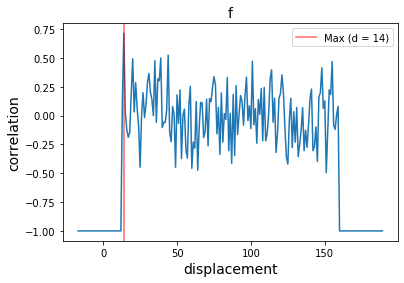

time short start - time short actual start = 75.75


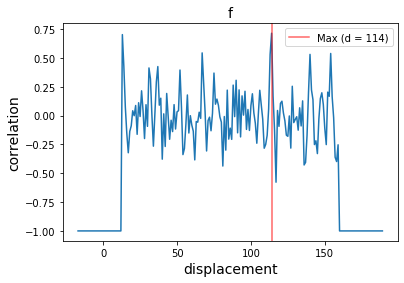

time short start - time short actual start = 67.45


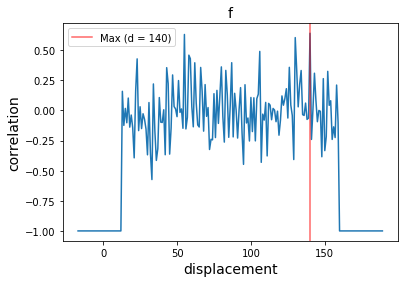

time short start - time short actual start = 66.55


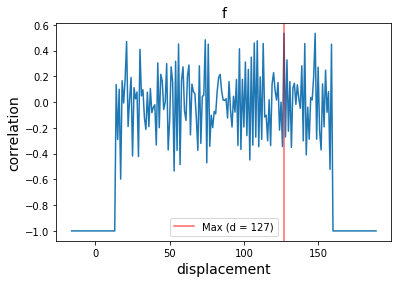

time short start - time short actual start = 69.55


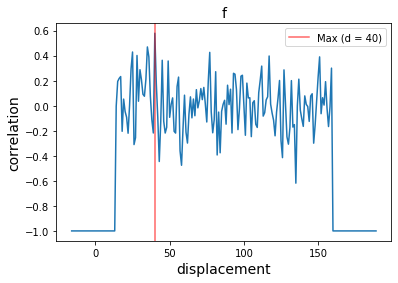

time short start - time short actual start = 79.95000000000002
68.525


In [58]:
res = get_parts_time_shift(pearson_correlation, 10, sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True, cut=(30,30))
print(np.mean(res))

## Dynamic Time Warping

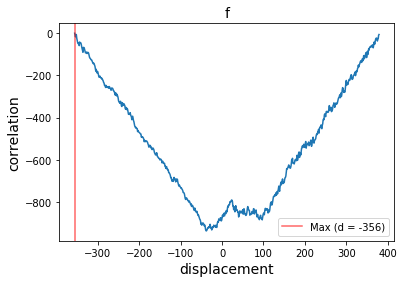

time short start - time short actual start = 67.45


67.45

In [59]:
calc_time_shift(dtw_metric, sig1, sig2, time1, time2, debug=True, cut=(0, 0))

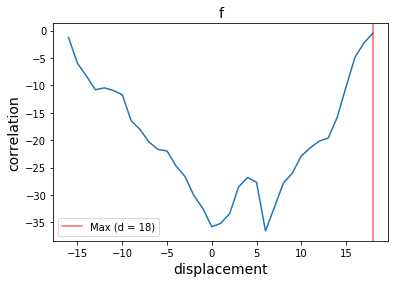

time short start - time short actual start = 50.64999999999999


50.64999999999999

In [60]:
sig1_filt, time1_filt = aggregate(sig1, time1, 1)
sig2_filt, time2_filt = aggregate(sig2, time2, 1)
calc_time_shift(dtw_metric, sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True, cut=(0, 0))

#### Subdividing signal into many parts and calculating time shifts for each

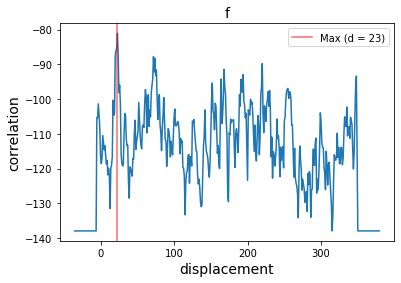

time short start - time short actual start = 67.5


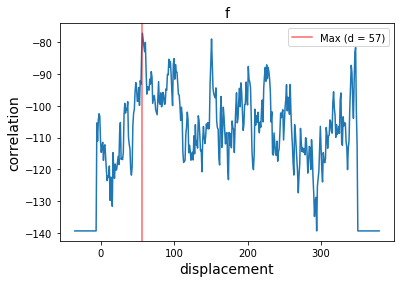

time short start - time short actual start = 67.55


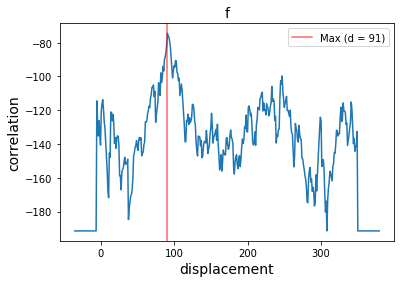

time short start - time short actual start = 67.6


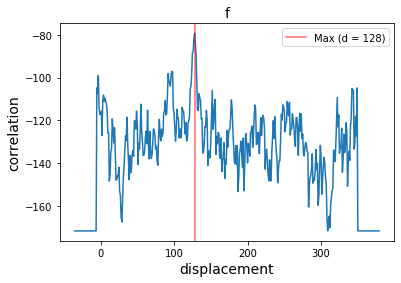

time short start - time short actual start = 67.5


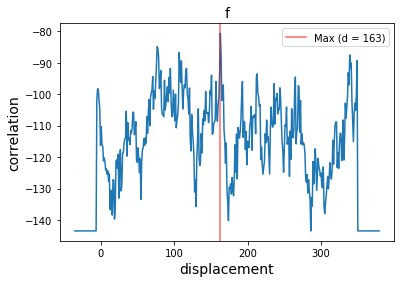

time short start - time short actual start = 67.5


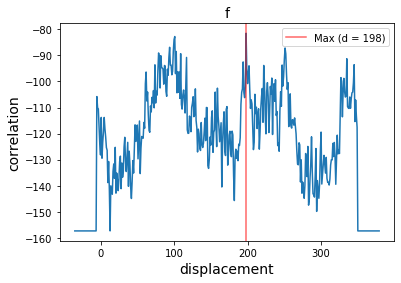

time short start - time short actual start = 67.5


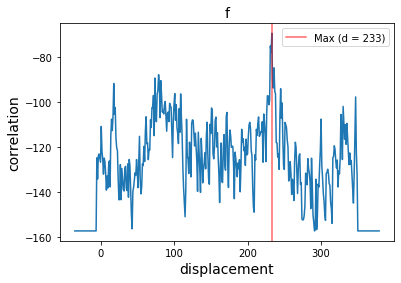

time short start - time short actual start = 67.5


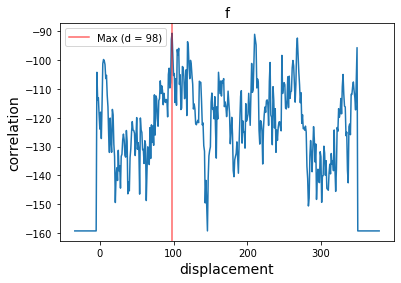

time short start - time short actual start = 76.0


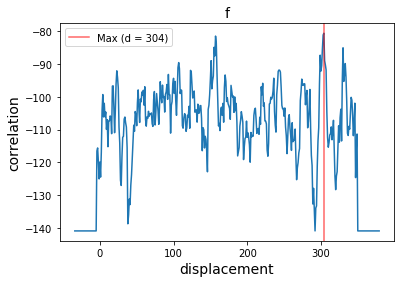

time short start - time short actual start = 67.44999999999999


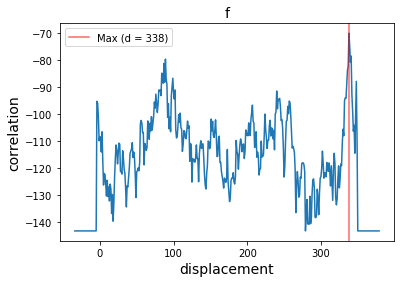

time short start - time short actual start = 67.5
68.35999999999999


In [61]:
res = get_parts_time_shift(dtw_metric, 10, sig1, sig2, time1, time2, debug=True, cut=(30,30))
print(np.mean(res))

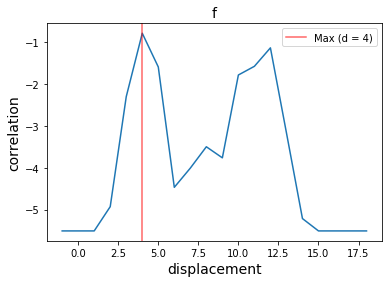

time short start - time short actual start = 64.65


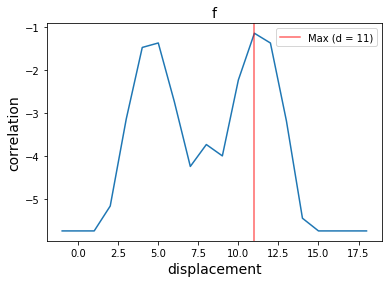

time short start - time short actual start = 58.64999999999999


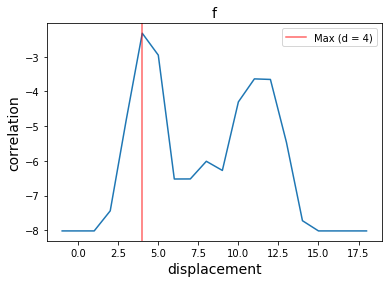

time short start - time short actual start = 66.65


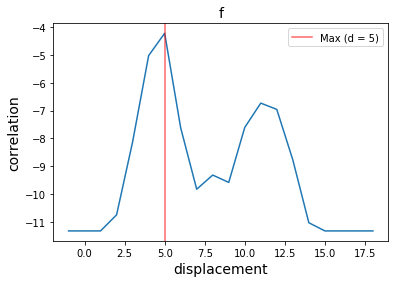

time short start - time short actual start = 66.65


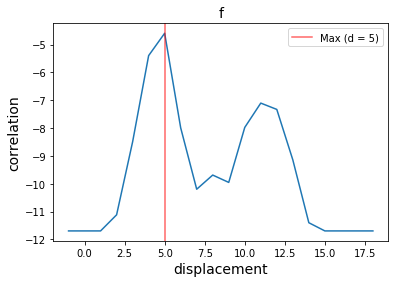

time short start - time short actual start = 67.65


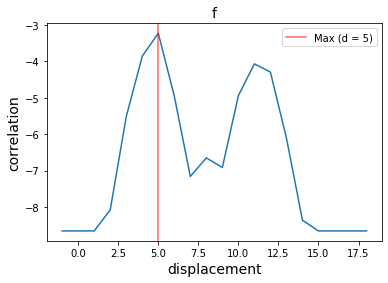

time short start - time short actual start = 68.65


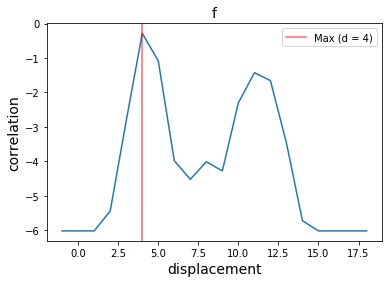

time short start - time short actual start = 70.65


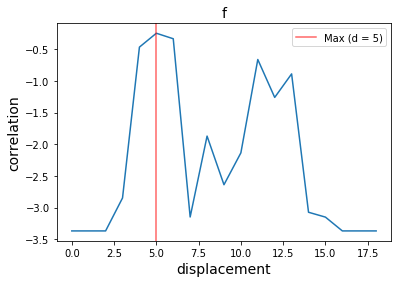

time short start - time short actual start = 70.65


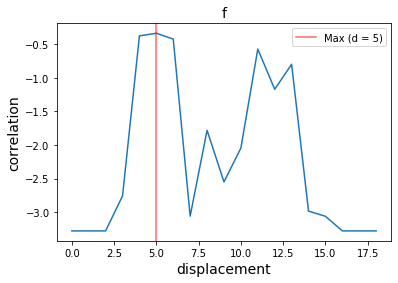

time short start - time short actual start = 71.65


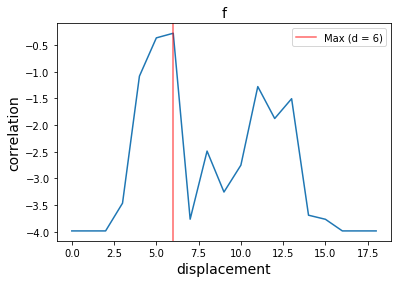

time short start - time short actual start = 71.65
67.75


In [62]:
res = get_parts_time_shift(dtw_metric, 10, sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True, cut=(3,3))
print(np.mean(res))

# Distribution similarities

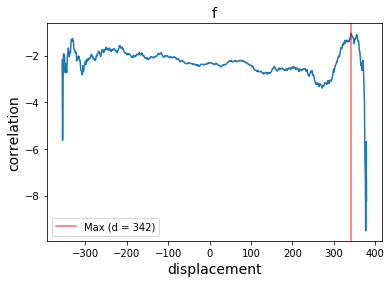

time short start - time short actual start = 51.54999999999999


51.54999999999999

In [65]:
calc_time_shift(wass_dist_metric, sig1, sig2, time1, time2, debug=True)

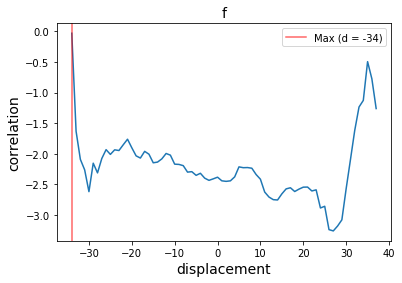

time short start - time short actual start = 66.65


66.65

In [64]:
sig1_filt, time1_filt = aggregate(sig1, time1, .5)
sig2_filt, time2_filt = aggregate(sig2, time2, .5)
calc_time_shift(wass_dist_metric, sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True, cut=(0, 0))

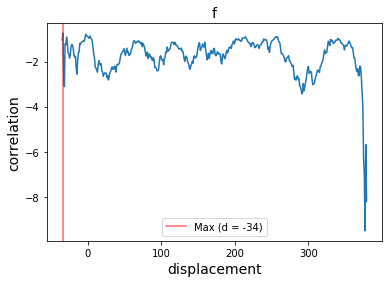

time short start - time short actual start = 51.349999999999994


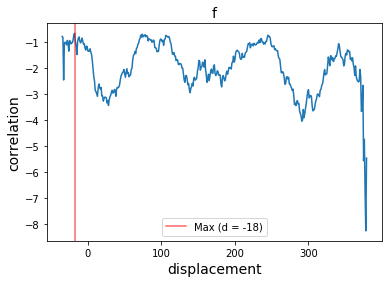

time short start - time short actual start = 52.29999999999999


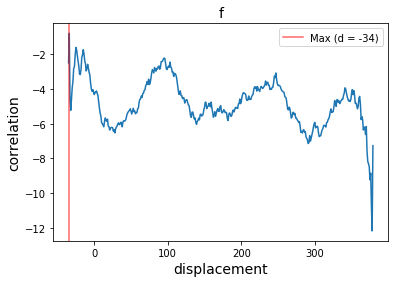

time short start - time short actual start = 54.849999999999994


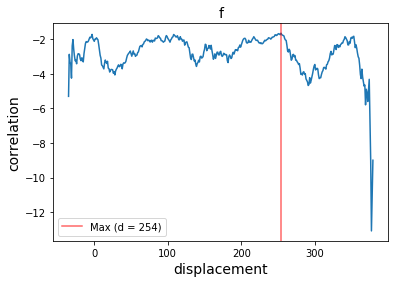

time short start - time short actual start = 61.199999999999996


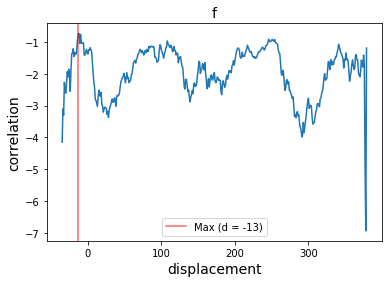

time short start - time short actual start = 57.29999999999999


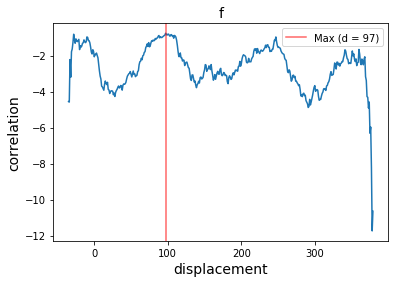

time short start - time short actual start = 72.55


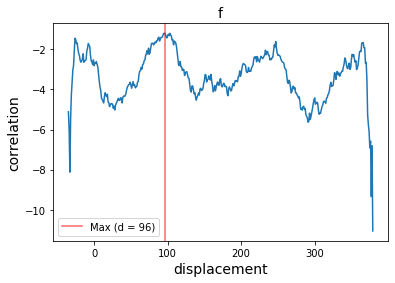

time short start - time short actual start = 74.35


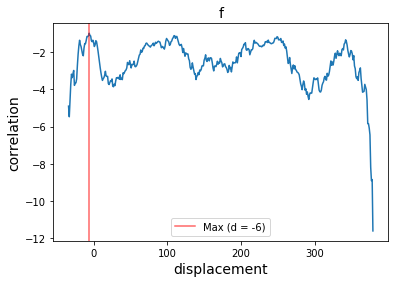

time short start - time short actual start = 62.19999999999999


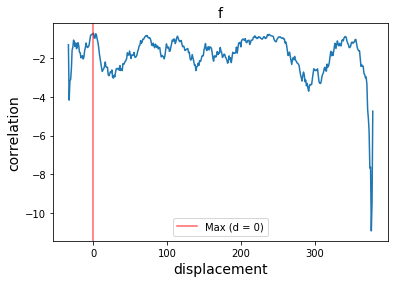

time short start - time short actual start = 82.65


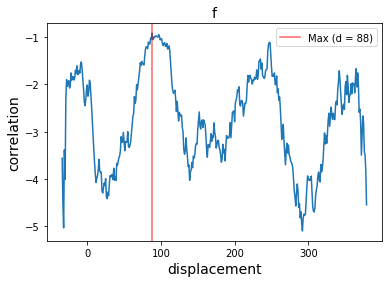

time short start - time short actual start = 80.00000000000001
64.87499999999999


In [66]:
res = get_parts_time_shift(wass_dist_metric, 10, sig1, sig2, time1, time2, debug=True)
print(np.mean(res))

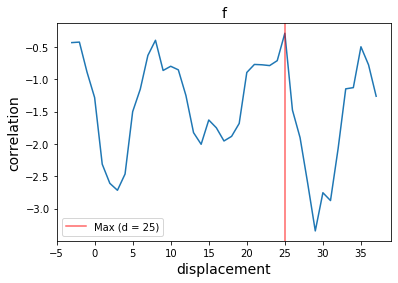

time short start - time short actual start = 56.14999999999999


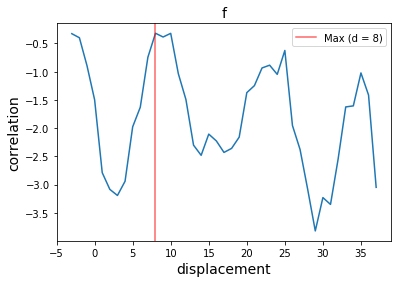

time short start - time short actual start = 66.15


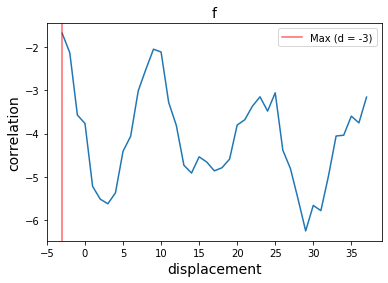

time short start - time short actual start = 54.14999999999999


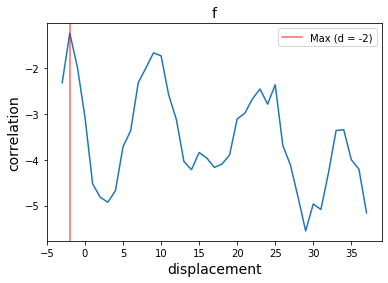

time short start - time short actual start = 55.14999999999999


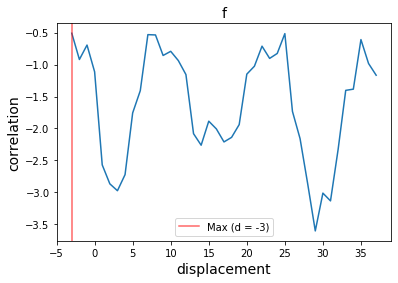

time short start - time short actual start = 57.14999999999999


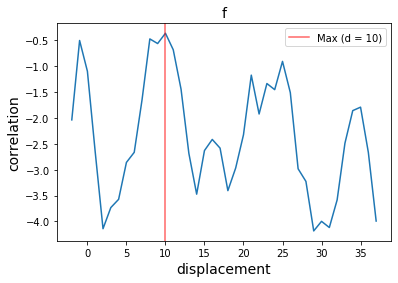

time short start - time short actual start = 71.15


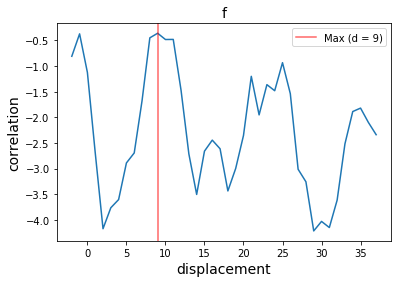

time short start - time short actual start = 73.15


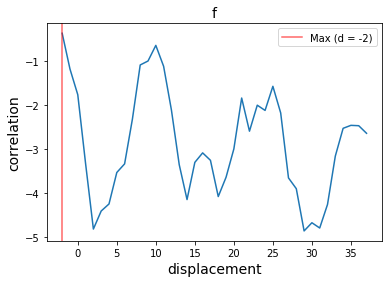

time short start - time short actual start = 61.14999999999999


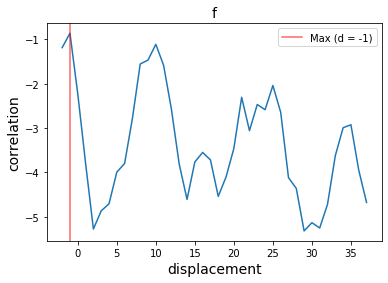

time short start - time short actual start = 62.14999999999999


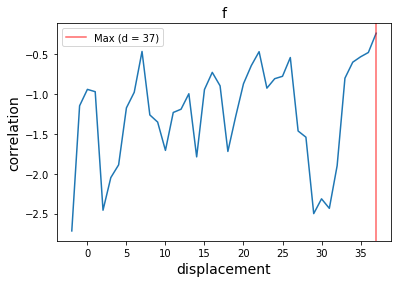

time short start - time short actual start = 63.64999999999999
62.0


In [67]:
res = get_parts_time_shift(wass_dist_metric, 10, sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True)
print(np.mean(res))

## Energy distance

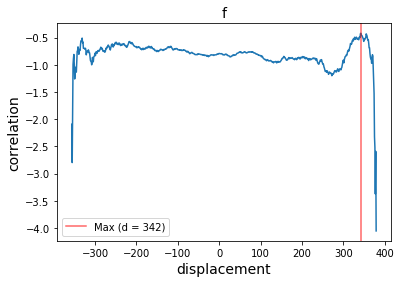

time short start - time short actual start = 51.54999999999999


51.54999999999999

In [74]:
calc_time_shift(energy_dist_metric, sig1, sig2, time1, time2, debug=True)

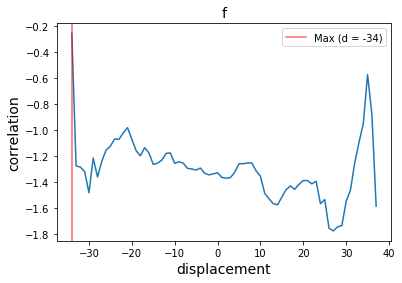

time short start - time short actual start = 66.65


66.65

In [75]:
sig1_filt, time1_filt = aggregate(sig1, time1, .5)
sig2_filt, time2_filt = aggregate(sig2, time2, .5)
calc_time_shift(energy_dist_metric, sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True, cut=(0, 0))

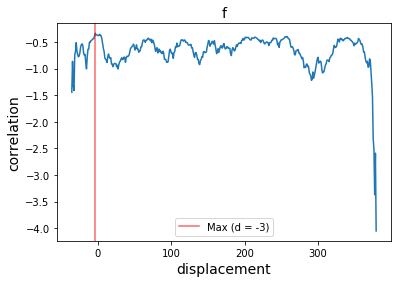

time short start - time short actual start = 49.79999999999999


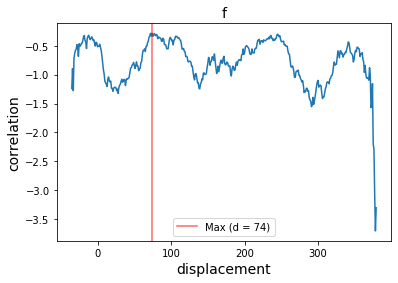

time short start - time short actual start = 66.7


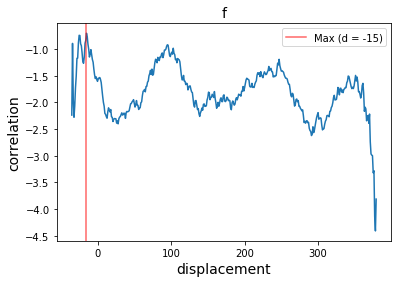

time short start - time short actual start = 53.89999999999999


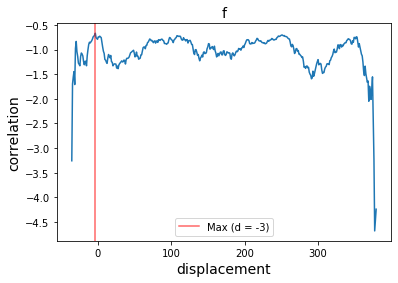

time short start - time short actual start = 55.04999999999999


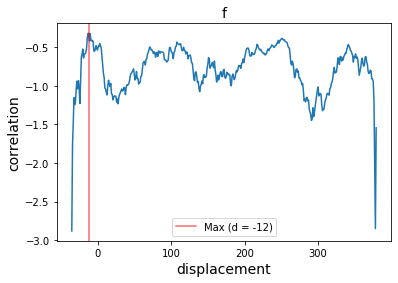

time short start - time short actual start = 57.249999999999986


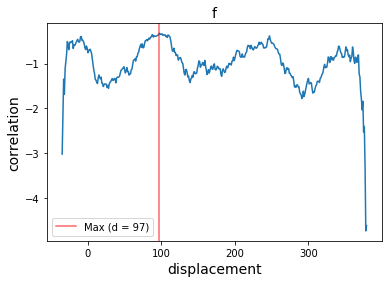

time short start - time short actual start = 72.55


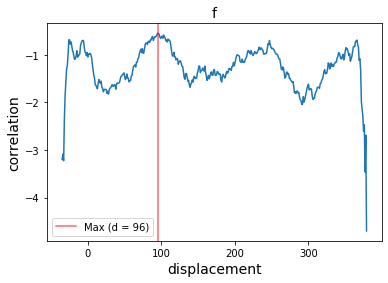

time short start - time short actual start = 74.35


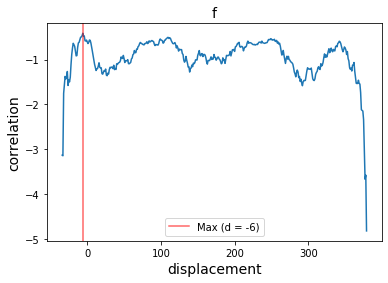

time short start - time short actual start = 62.19999999999999


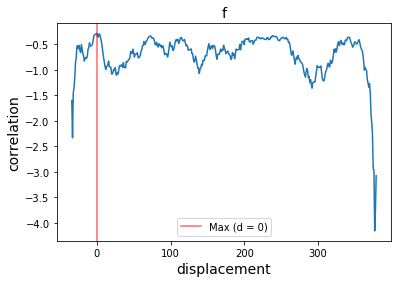

time short start - time short actual start = 82.65


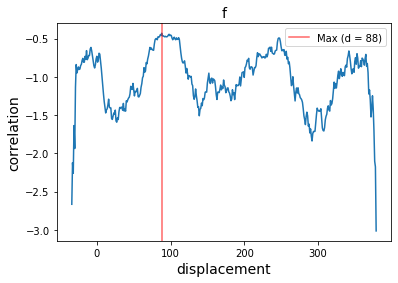

time short start - time short actual start = 80.00000000000001
65.445


In [76]:
res = get_parts_time_shift(energy_dist_metric, 10, sig1, sig2, time1, time2, debug=True)
print(np.mean(res))

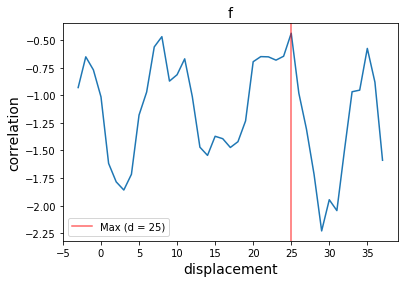

time short start - time short actual start = 56.14999999999999


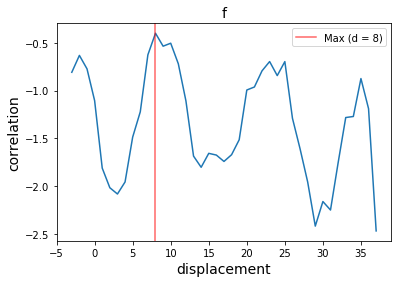

time short start - time short actual start = 66.15


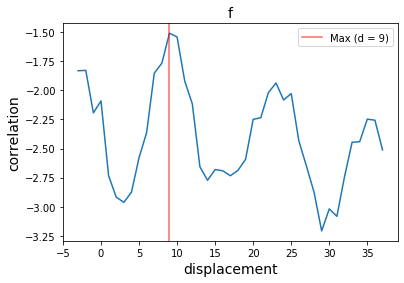

time short start - time short actual start = 67.15


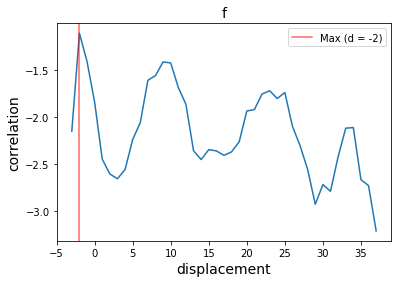

time short start - time short actual start = 55.14999999999999


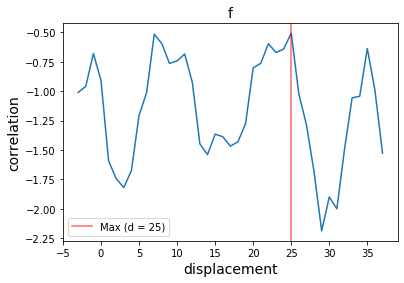

time short start - time short actual start = 62.14999999999999


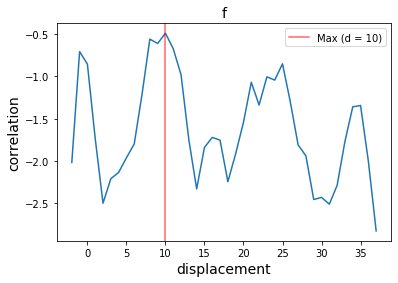

time short start - time short actual start = 71.15


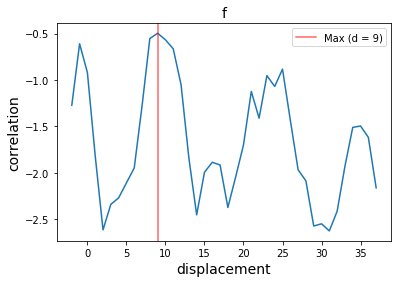

time short start - time short actual start = 73.15


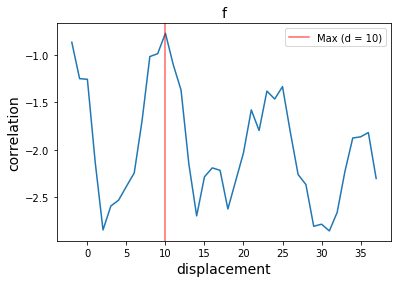

time short start - time short actual start = 74.15


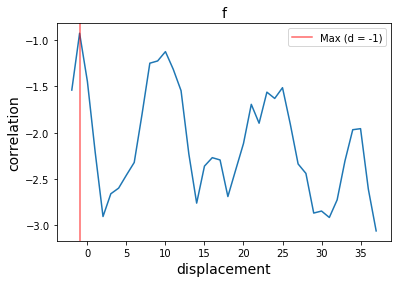

time short start - time short actual start = 62.14999999999999


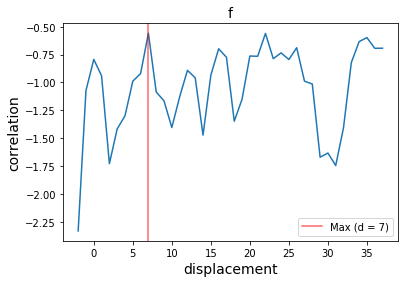

time short start - time short actual start = 78.65
66.6


In [77]:
res = get_parts_time_shift(energy_dist_metric, 10, sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True)
print(np.mean(res))

## Spectral Power Metric

In [78]:
from scipy.signal import periodogram

In [96]:
periodogram?

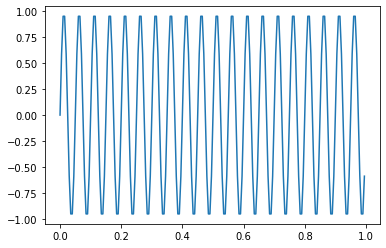

<ipython-input-114-31044e2bb887>:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(f, pw)


<StemContainer object of 3 artists>

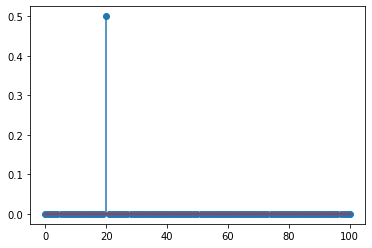

In [114]:
f = 20
fs = 10*f
end = 2*np.pi
x = np.arange(0, 1, 1/fs)
y = np.sin(2*np.pi*f*x)
z = np.sin(2*np.pi*f*2*x)
f, pw = periodogram(y,fs)
plt.figure()
plt.plot(x, y)
plt.show()
plt.figure()
plt.stem(f, pw)

In [137]:
f1, pw1 = periodogram(sig1, 1/0.05)
f2, pw2 = periodogram(sig2, 1/0.05)

In [124]:
np.diff(f2)

array([0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602241,
       0.05602241, 0.05602241, 0.05602241, 0.05602241, 0.05602

In [131]:
plt.stem?

<ipython-input-144-8bba0d99d970>:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(f1, pw1, 'b', markerfmt='bo')
<ipython-input-144-8bba0d99d970>:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(f2, pw2, 'r', markerfmt='ro')


<StemContainer object of 3 artists>

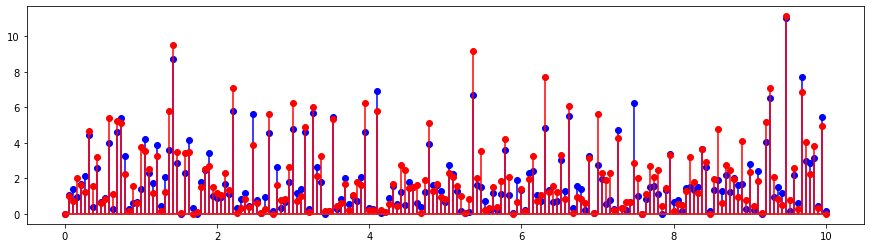

In [144]:
plt.figure(figsize=(15,4))
plt.stem(f1, pw1, 'b', markerfmt='bo')
plt.stem(f2, pw2, 'r', markerfmt='ro')
# plt.figure(figsize=(15,4))


<ipython-input-125-729c090e713d>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(f2, pw2)


<StemContainer object of 3 artists>

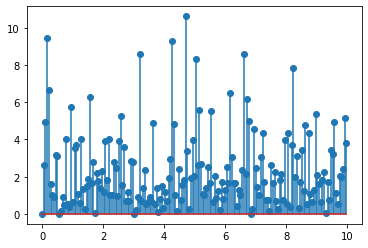